In [ ]:
import numpy
print('numpy:', numpy.__version__)

import scipy
print('scipy:', scipy.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)

import IPython
print('iPython:', IPython.__version__)

import sklearn
print('scikit-learn:', sklearn.__version__)

numpy: 1.26.4
scipy: 1.13.1
matplotlib: 3.7.1
iPython: 7.34.0
scikit-learn: 1.3.2


In [ ]:
import keras
print("keras: ", keras.__version__)

import tensorflow as tf
print("Tensorflow: ", tf.__version__)

keras:  3.4.1
Tensorflow:  2.17.0


In [ ]:
pip install -q wfdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
        %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from wfdb import processing
from keras import optimizers
from keras.layers import Convolution1D, MaxPool1D, Dropout, Input, GlobalMaxPool1D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras import activations
from keras.models import Sequential
from keras.regularizers import L1L2
from keras.layers import Dense, Dropout, LSTM
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import SimpleRNN
from keras.layers import Bidirectional
from keras.utils import plot_model
from tensorflow.python.keras.engine.sequential import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [ ]:
from wfdb import io, plot

# The folder where you want to get your data from
data_folder = '/content/drive/MyDrive/Dissertation/ptb-diagnostic-ecg-database-1.0.0'

record_names = io.get_record_list('ptbdb')

channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]



In [ ]:
data_dir = "/content/drive/My Drive/Dissertation/"
output_folder = '/content/drive/MyDrive/Dissertation/dataset/new_folder'

In [ ]:

from tqdm import tqdm
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join(data_folder, record_name))
    #label = comments_to_dict(record.comments)['Reason for admission'][1:]
    label = record.comments[4].split(": ")[-1]
    patient = record_name.split('/')[0]
    signal_length = record.sig_len
    records.append({'name':record_name, 'label':label, 'patient':patient,
                    'signal_length':signal_length})

channels = record.sig_name
df_records = pd.DataFrame(records)

100%|██████████| 549/549 [00:30<00:00, 18.25it/s]


In [ ]:
#df_records.to_csv(data_dir+'records.csv')
df_recrods = pd.read_csv('/content/drive/My Drive/Dissertation/records.csv')
df_recrods.head()


,Unnamed: 0,name,label,patient,signal_length
0,0,patient001/s0010_re,Myocardial infarction,patient001,38400
1,1,patient001/s0014lre,Myocardial infarction,patient001,115200
2,2,patient001/s0016lre,Myocardial infarction,patient001,115200
3,3,patient002/s0015lre,Myocardial infarction,patient002,115200
4,4,patient003/s0017lre,Myocardial infarction,patient003,115200


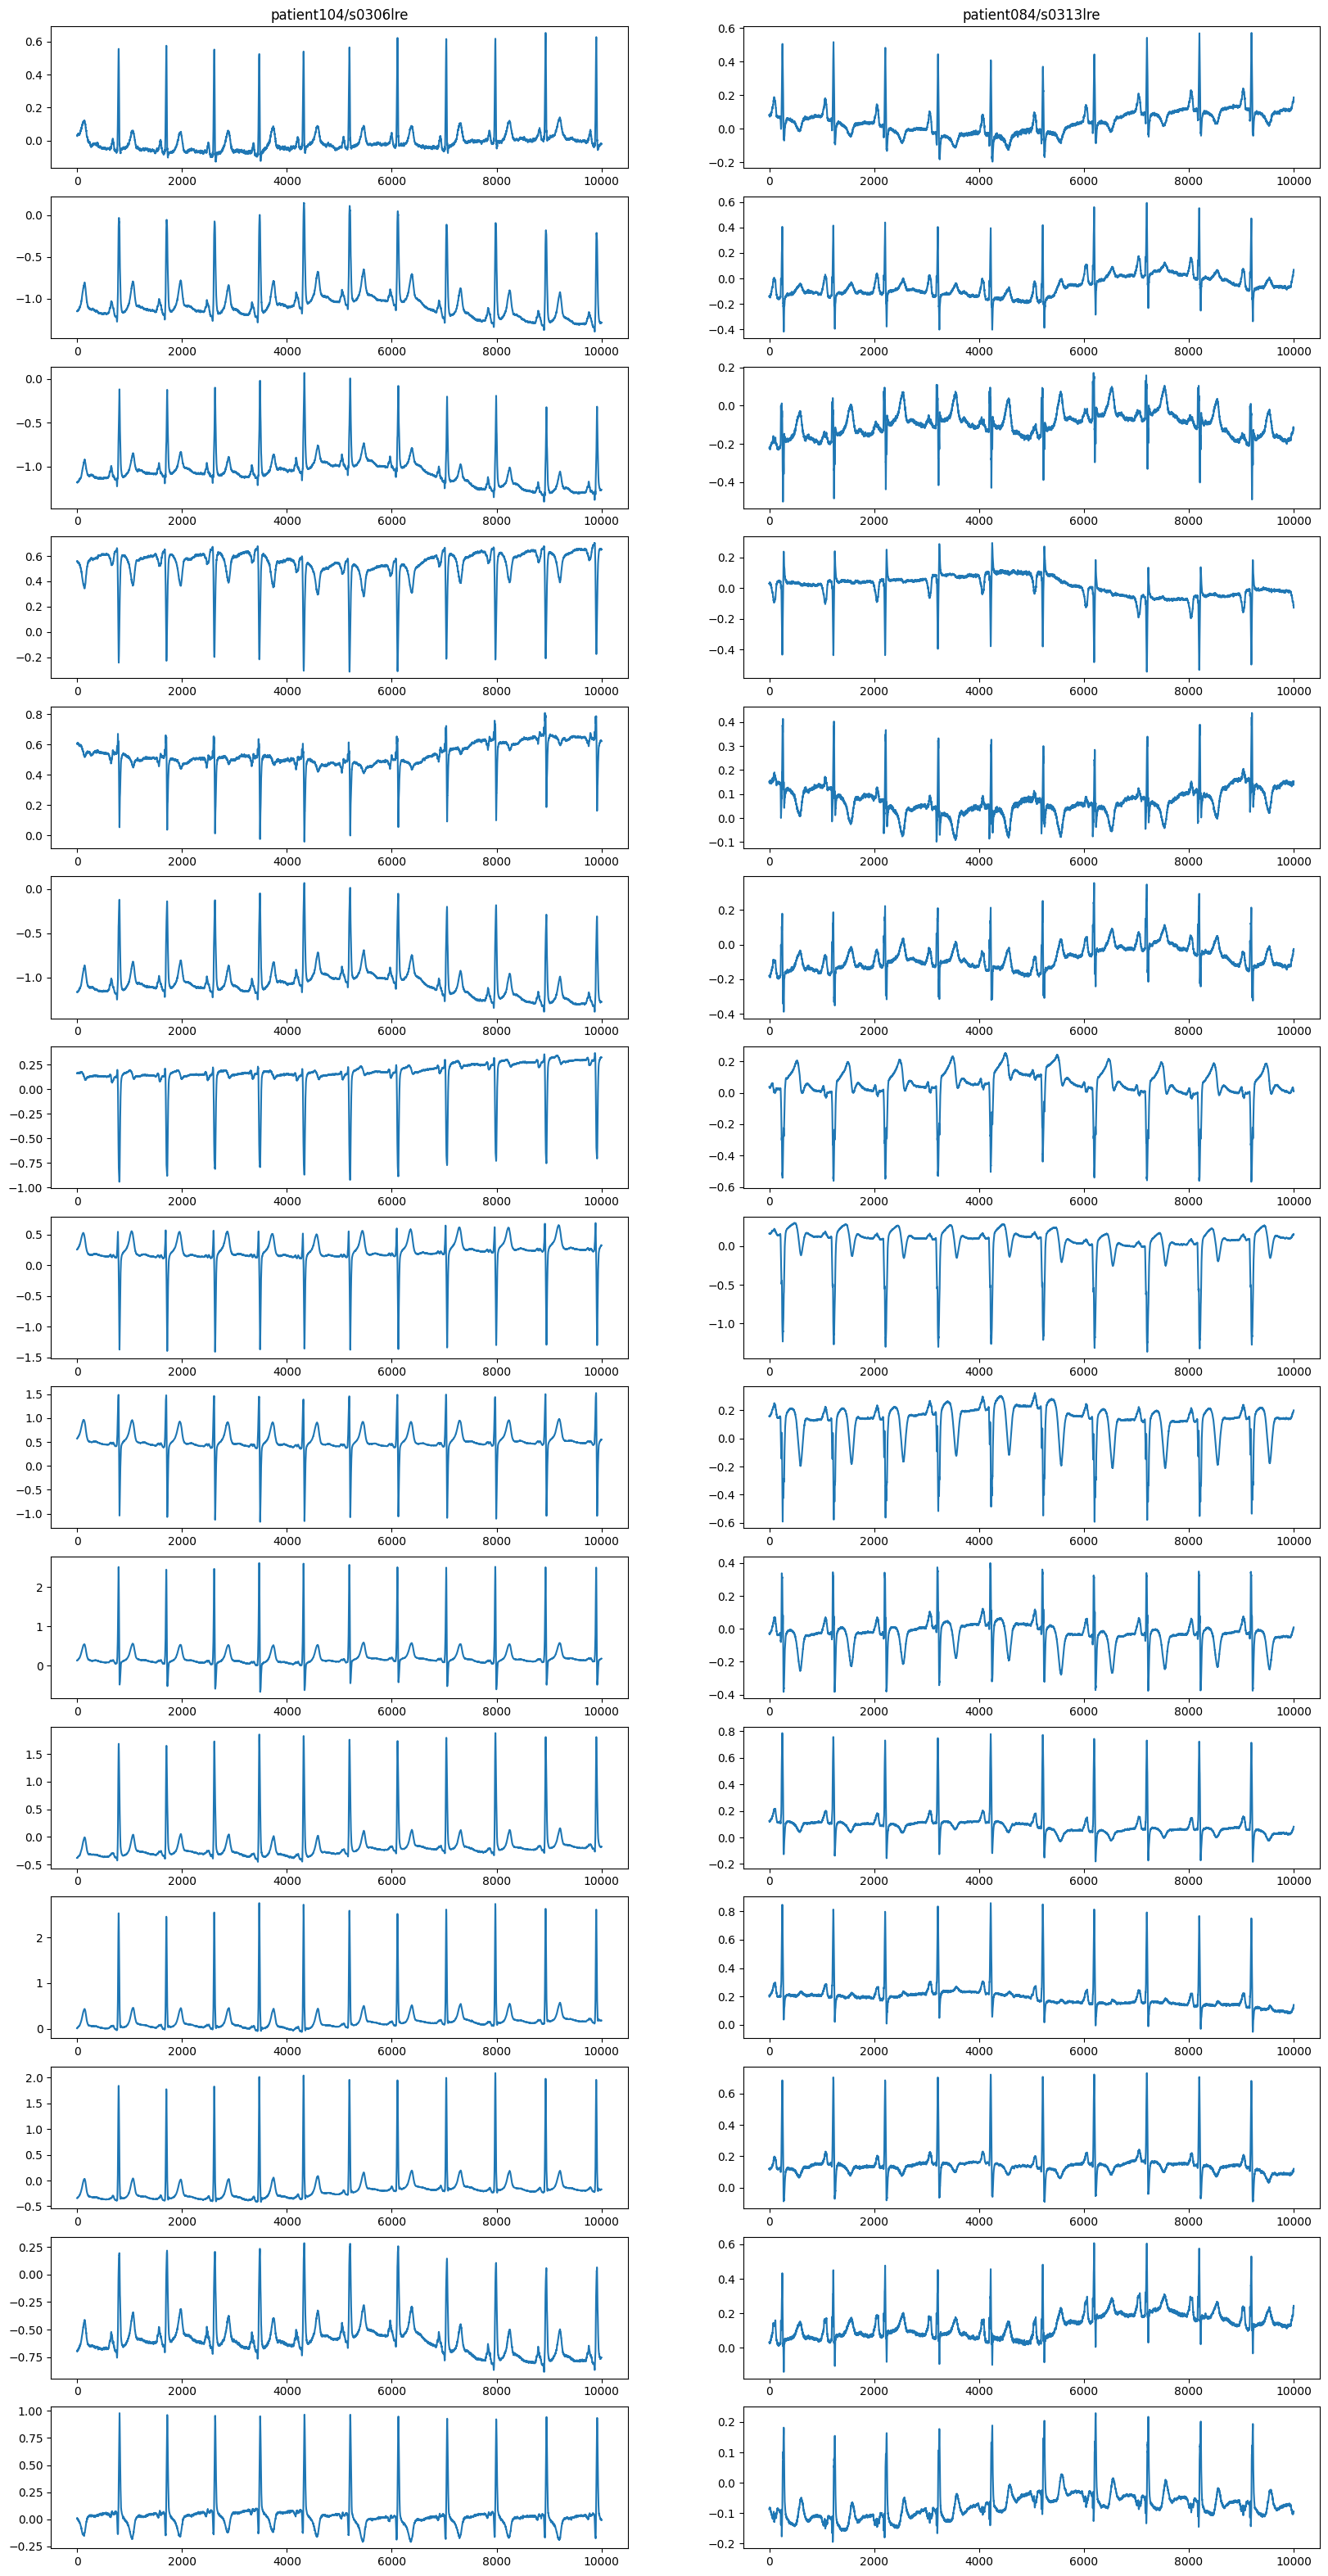

In [ ]:
# get the first occurance of healthy and myocardial infarction
control = df_records[df_records['label'] == 'Healthy control'].iloc[0]
infarct = df_records[df_records['label'] == 'Myocardial infarction'].iloc[250]


# Get the signal data
control_data = io.rdrecord(os.path.join(data_folder, control['name'])).p_signal
infarct_data = io.rdrecord(os.path.join(data_folder, infarct['name'])).p_signal

# Transpose the data for easier handling
control_data = np.transpose(control_data)
infarct_data = np.transpose(infarct_data)

# plot data
fig, axes = plt.subplots(15, 2, figsize=(20, 40))

for idx, (control_channel, infarct_channel) in enumerate(zip(control_data, infarct_data)):
    axes[idx][0].plot(control_channel[0:10000])
    if idx == 0:
        axes[idx][0].set_title(control['name'])
    axes[idx][1].plot(infarct_channel[0:10000])
    if idx == 0:
        axes[idx][1].set_title(infarct['name'])

In [ ]:
dfs=[]
a=1
for filename in os.listdir(output_folder):
  filename =pd.read_csv(os.path.join(output_folder,filename))
  dfs.append(filename)

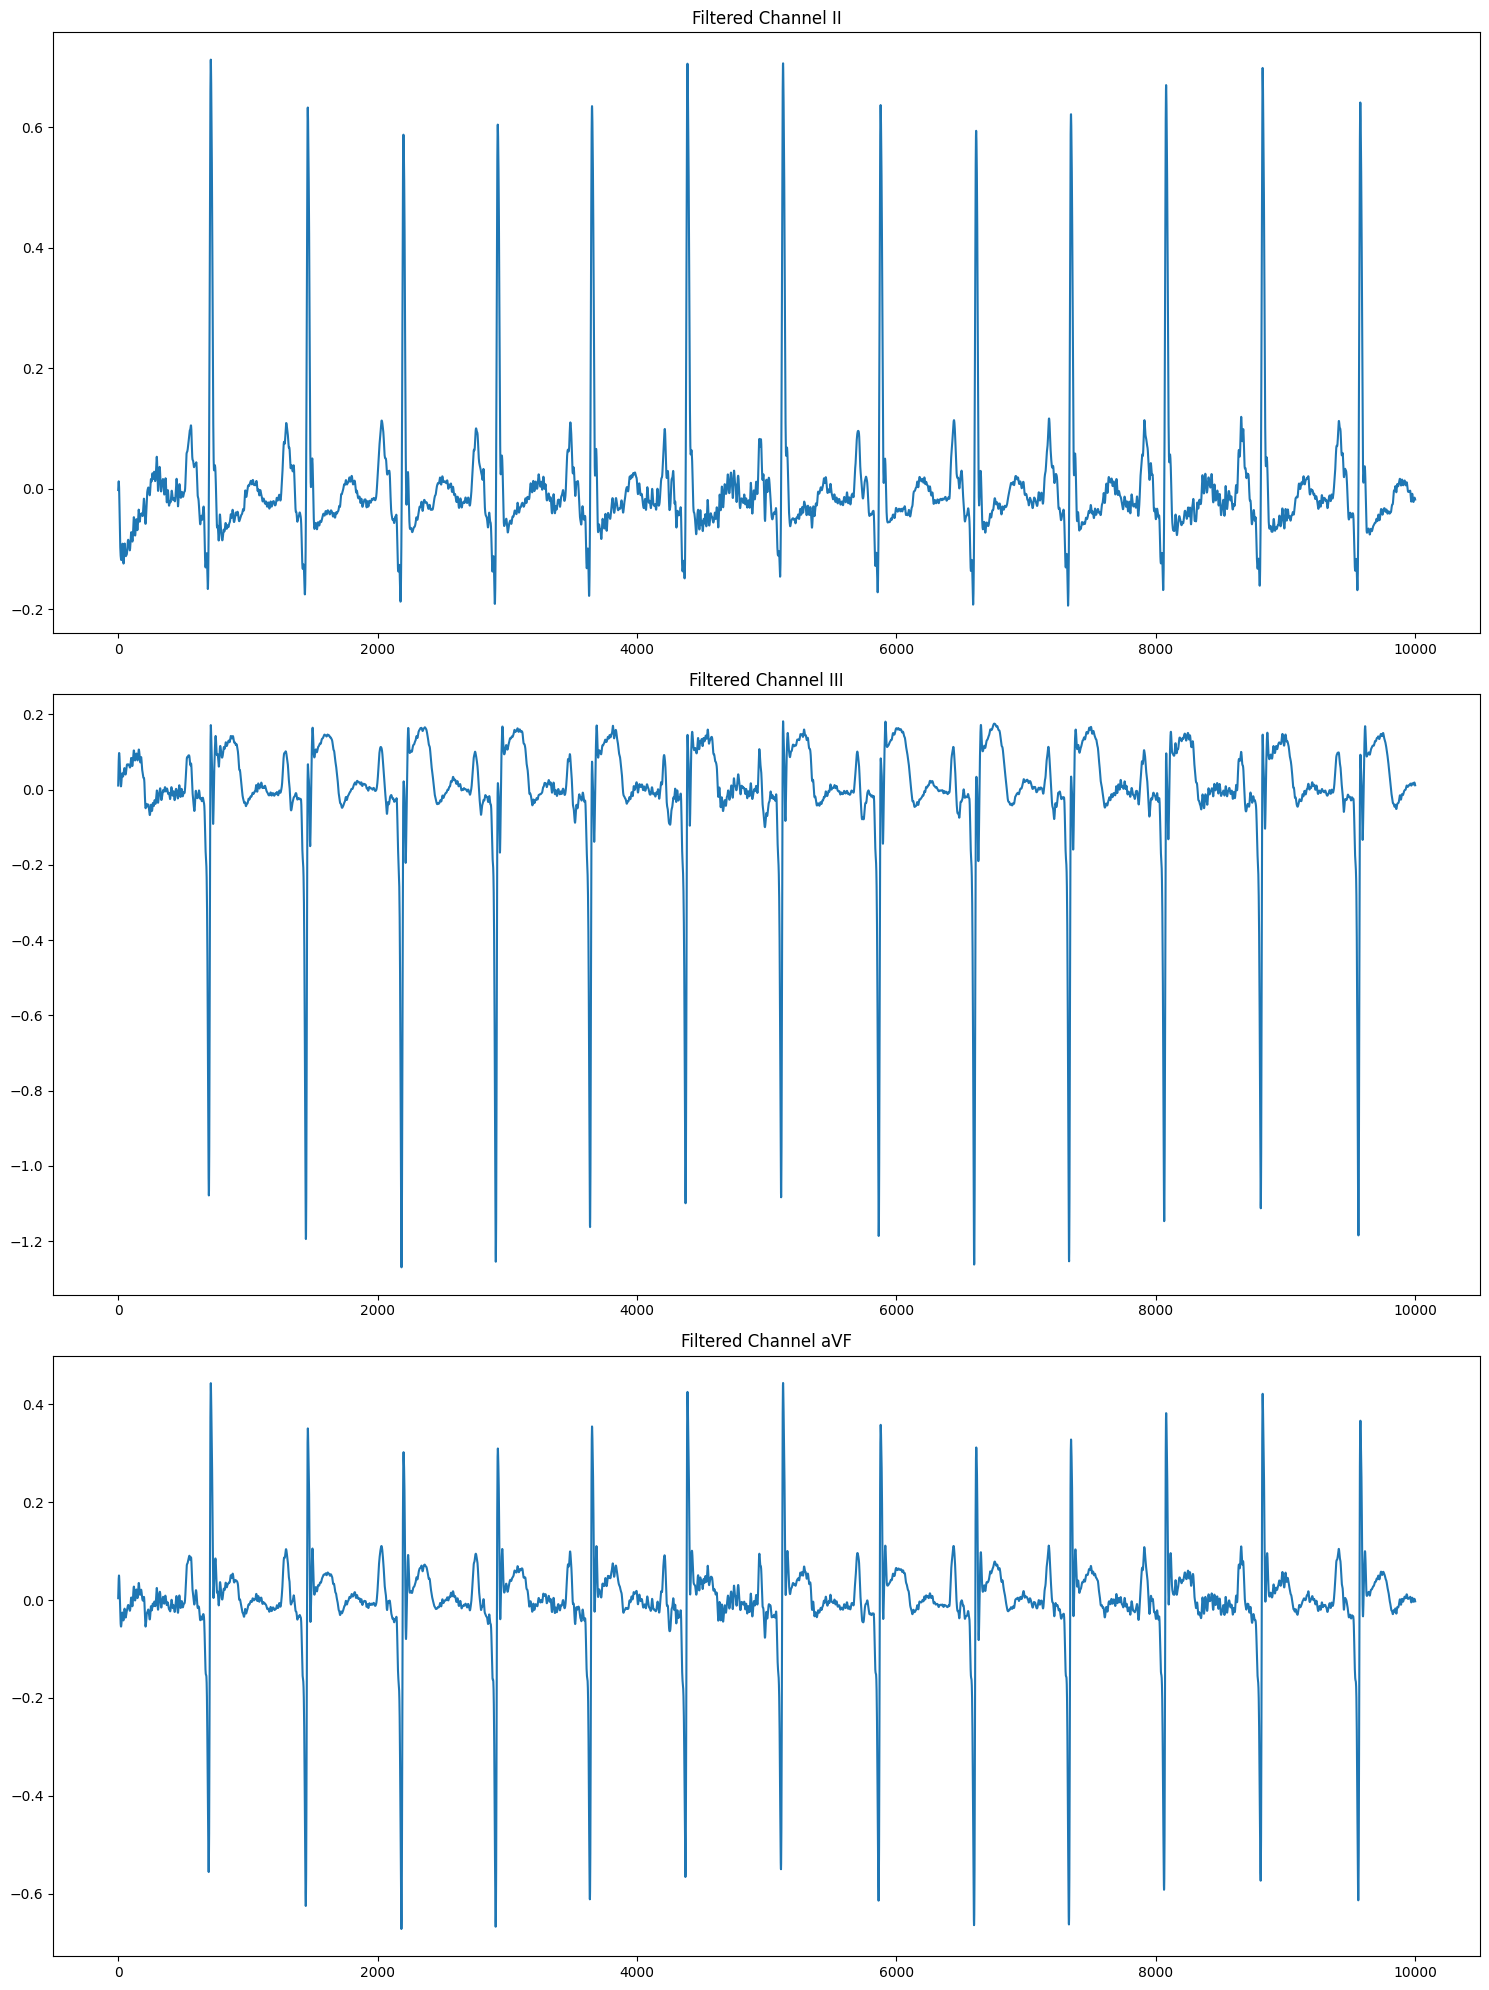

In [ ]:
df=dfs[0]
signals_array = df[['ii', 'iii', 'avf']].values

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# Example filter parameters (adjust as needed)
lowcut = 0.5  # Hz
highcut = 40.0  # Hz
fs = 500  # Sampling frequency (adjust based on your data)

# Apply the filter to the entire signal array
filtered_signals = butter_bandpass_filter(signals_array, lowcut, highcut, fs)

# Visualize the filtered signals
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))


# Plot each filtered channel in a separate subplot
axes[0].plot(df[0:10000].index, filtered_signals[:10000, 0])
axes[0].set_title('Filtered Channel II')

axes[1].plot(df[0:10000].index, filtered_signals[:10000, 1])
axes[1].set_title('Filtered Channel III')

axes[2].plot(df[0:10000].index, filtered_signals[:10000, 2])
axes[2].set_title('Filtered Channel aVF')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

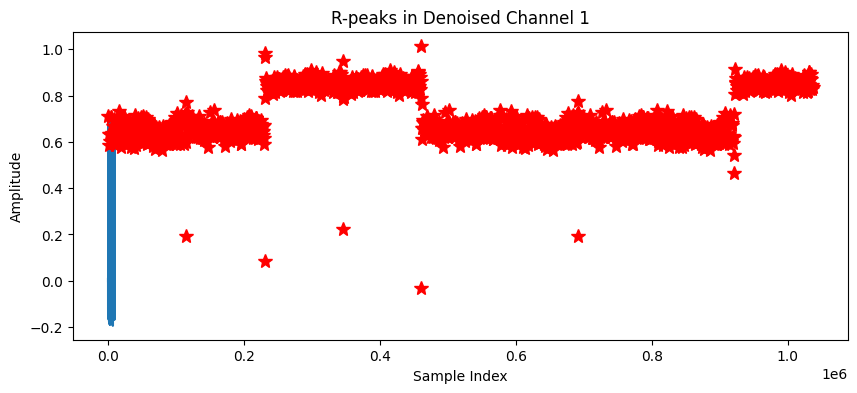

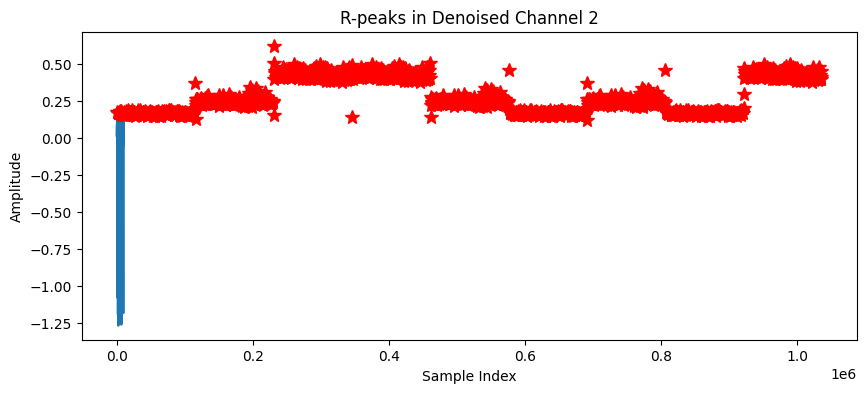

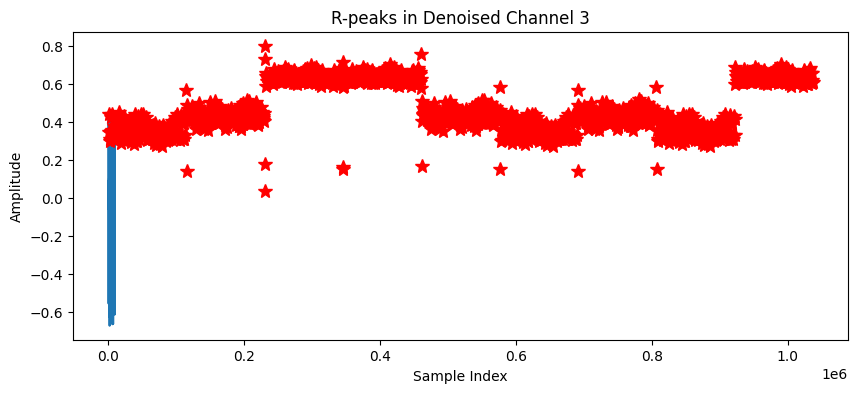

In [ ]:
for channel_idx in range(filtered_signals.shape[1]):
    # Find peaks in the signal
    peaks, _ = find_peaks(filtered_signals[:, channel_idx], prominence=0.5)  # Adjust prominence as needed

    # Plot the signal and mark R-peaks with stars
    plt.figure(figsize=(10, 4))
    plt.plot((filtered_signals[:, channel_idx])[0:10000])
    plt.plot(peaks, filtered_signals[peaks, channel_idx], "r*", markersize=10)
    plt.title(f"R-peaks in Denoised Channel {channel_idx+1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


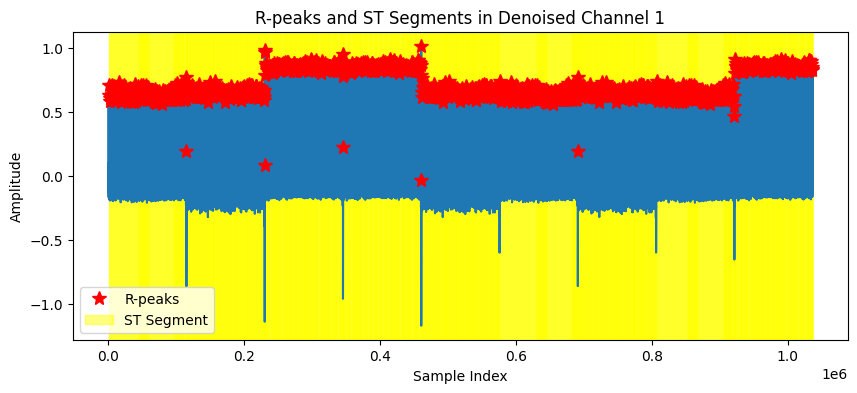

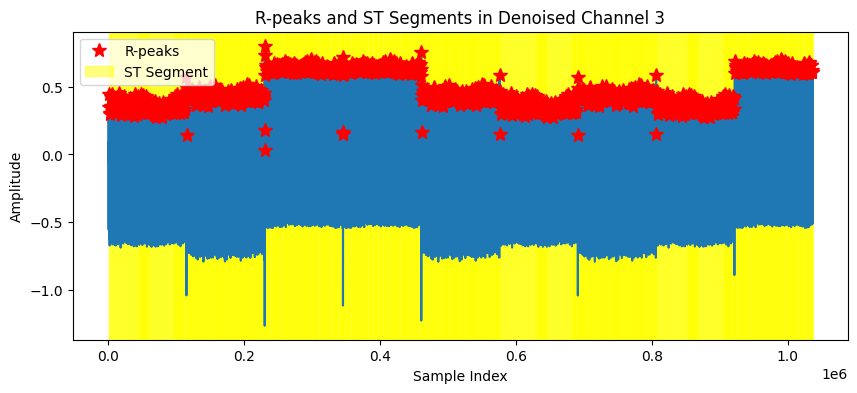

In [ ]:
channel_1_idx = 0
channel_5_idx = 2

# Iterate through selected channels
for channel_idx in [channel_1_idx, channel_5_idx]:
    # Find peaks in the signal
    peaks, _ = find_peaks(filtered_signals[:, channel_idx], prominence=0.5)  # Adjust prominence as needed

    # Estimate average RR interval
    rr_intervals = np.diff(peaks)
    avg_rr_interval = np.mean(rr_intervals)

    # Mark ST segments
    st_start = peaks + int(0.1 * avg_rr_interval)  # Start 10% after R-peak
    st_end = peaks + int(0.4 * avg_rr_interval)    # End 40% after R-peak

    # Ensure indices are within bounds
    st_start = np.clip(st_start, 0, len(filtered_signals) - 1)
    st_end = np.clip(st_end, 0, len(filtered_signals) - 1)

    # Plot the signal and mark R-peaks and ST segments
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_signals[:, channel_idx])
    plt.plot(peaks, filtered_signals[peaks, channel_idx], "r*", markersize=10, label="R-peaks")

    for start, end in zip(st_start, st_end):
        plt.axvspan(start, end, color='yellow', alpha=0.5, label="ST Segment" if start == st_start[0] else "")

    plt.title(f"R-peaks and ST Segments in Denoised Channel {channel_idx+1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


In [ ]:
infarct

,250
name,patient084/s0313lre
label,Myocardial infarction
patient,patient084
signal_length,115200


In [ ]:
selected_labels = ['Healthy control',
                   'Myocardial infarction']
# The label map will be used to do one-hot label encoding
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

test_patients = []
train_patients = []

# We will use 80% of available subject to train the model and
# remaining 20% to test the model
test_size = 0.2

# randomly divide the subjects in training and test set
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients) * test_size)
    test_patients += list(np.random.choice(patients, n_test, replace=False))
    train_patients += list(patients[np.isin(patients, test_patients, invert=True)])


In [ ]:
def preprocess(sig):
    sig_resampled, _ = processing.resample_sig()

In [ ]:
def make_set(df_data, label_map, record_id, window_size=None, n_channels=12):
  """
  1. load ecg data from the records specified in df_data
  2. Divide signal data using window size

  parameters
  -----------
  df_data: DataFrame
      a DataFrame containing metadata about each patients
  label_map: Dict
      a dictionary containing labels and on hot encoded labels

  record_id: List
      a list to keep track to whom each sequence goes to
  window_size: int
      a number that defines segmented ECG


  Returns
  -----------

        dataX: contains windowed ecg data: shape = [n_windows, n_channels, window_size]
        dataY: contains label for each window
        record_id: if required also returns a list specifying record_name for each window # important for interpretabilty

  """
  n_windows = 0 # number of windowed ECG data
  for _, record in df_data.iterrows():
    n_windows +=record['signal_length'] // window_size

  dataX = np.zeros((n_windows, n_channels, window_size))
  dataY = np.zeros((n_windows, len(label_map)))

  record_list = []

  nth_window =  0

  for i, (patient, record) in enumerate(df_data.iterrows()):
    signal_data = io.rdrecord(os.path.join(data_folder, record['name']), channels=channels).p_signal.transpose()
    n_rows = signal_data.shape[-1]
    n_windows = n_rows // window_size
    dataX[nth_window:nth_window+n_windows] = np.array([signal_data[:, i*window_size:(i+1)*window_size] for i in range(n_windows)])
    #print(dataX.shape)
    dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
    #print(dataY.shape)
    nth_window += n_windows

    if record_id:
      record_list += n_windows * [record['name']]

  return dataX, dataY, record_list






In [ ]:
channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
# Set the patient as the index of dataframe to easily extract the metadata by patient
df_patient_records = df_records.set_index('patient')

# Select the metadata of the patient we need
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[test_patients]

window_size = 2048

trainX, trainY, _ = make_set(df_train_patients, label_map, False, window_size, 12)
testX, testY, record_list = make_set(df_test_patients, label_map, True, window_size, 12)

In [ ]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((19793, 12, 2048), (19793, 2), (4766, 12, 2048), (4766, 2))

In [ ]:
testY[:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
record_list[:3]

['patient116/s0302lre', 'patient116/s0302lre', 'patient116/s0302lre']

In [ ]:
np.random.seed(1337)

In [ ]:


def make_model(input_shape, output_dim, dropout=0.2):
    print("Model dimensions:", input_shape, output_dim)

    # Define the Sequential model
    model = Sequential()

    # Adding an Input layer
    model.add(Input(shape=input_shape))

    # Adding LSTM layers with Batch Normalization
    model.add(LSTM(256, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(LSTM(64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(LSTM(32))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    # Adding the output layer
    model.add(Dense(output_dim, activation='softmax'))

    # Compile the model
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()
    return model

# Shuffle the data
trainX, trainY = shuffle(trainX, trainY)

# Calculate sample weights to handle class imbalance
fractions = 1 - trainY.sum(axis=0) / len(trainY)
weights = fractions[trainY.argmax(axis=1)]

# Define callbacks
ec = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_LSTM_model.keras', monitor='val_acc', mode='max', verbose=1)
callbacks = [ec, mc]

# Build the model
model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])

# Train the model
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50,
          batch_size=128, sample_weight=weights, callbacks=callbacks)


Model dimensions: (12, 2048) 2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 12, 256)             │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 12, 64)              │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,456,386 (9.37 MB)

 Trainable params: 2,455,682 (9.37 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.5436 - loss: 0.2684
Epoch 1: saving model to best_LSTM_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 85s 506ms/step - accuracy: 0.5437 - loss: 0.2683 - val_accuracy: 0.6433 - val_loss: 0.6163
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6245 - loss: 0.2023
Epoch 2: saving model to best_LSTM_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 74s 456ms/step - accuracy: 0.6246 - loss: 0.2023 - val_accuracy: 0.5533 - val_loss: 0.7774
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6639 - loss: 0.1897
Epoch 3: saving model to best_LSTM_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 71s 461ms/step - accuracy: 0.6639 - loss: 0.1897 - val_accuracy: 0.6255 - val_loss: 0.7229
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6940 - loss: 0.1766
Epoch 4: saving model to best_LSTM_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 462ms/step - accuracy: 0.6940 - loss: 0.1765 - val_accuracy: 0.7253

In [ ]:
#Training model with 3 leads

# Shuffle the data
trainX, trainY = shuffle(trainX, trainY)

# Calculate sample weights to handle class imbalance
fractions = 1 - trainY.sum(axis=0) / len(trainY)
weights = fractions[trainY.argmax(axis=1)]

# Define callbacks
ec = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_LSTM_model.keras', monitor='val_acc', mode='max', verbose=1)
callbacks = [ec, mc]

# Build the model
model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])

# Train the model
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50,
          batch_size=128, sample_weight=weights, callbacks=callbacks)


Model dimensions: (3, 2048) 2


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 3, 256)              │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 3, 64)               │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 3, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,456,386 (9.37 MB)

 Trainable params: 2,455,682 (9.37 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5215 - loss: 0.2522
Epoch 1: saving model to best_LSTM_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.5215 - loss: 0.2521 - val_accuracy: 0.4420 - val_loss: 0.7057
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5439 - loss: 0.2303
Epoch 2: saving model to best_LSTM_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.5439 - loss: 0.2303 - val_accuracy: 0.5251 - val_loss: 0.6677
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5549 - loss: 0.2219
Epoch 3: saving model to best_LSTM_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.5549 - loss: 0.2219 - val_accuracy: 0.6388 - val_loss: 0.6153
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5550 - loss: 0.2266
Epoch 4: saving model to best_LSTM_model.keras
151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.5550 - loss: 0.2265 - val_accuracy: 0.6149

In [ ]:
model.history.history.keys()

dict_keys([])

In [ ]:
test_loss, test_acc = model.evaluate(testX, testY)
print("accurcy: %0.2f" % test_acc)

151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.7083 - loss: 0.7040
accurcy: 0.81


In [ ]:
model.save("drive/My Drive/3_layer_LSTM_12.1_leads.keras")

In [ ]:
model.save("drive/My Drive/3_layer_LSTM_3.1_leads.keras")

In [ ]:
model12= tf.keras.models.load_model("drive/My Drive/3_layer_LSTM_12.1_leads.keras")

In [ ]:
model3= tf.keras.models.load_model("drive/My Drive/3_layer_LSTM_3.1_leads.keras")

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix - 3 leads")
    else:
        print('Confusion matrix, without normalization - 3 leads')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Predict the label for each sequences
y_pred = model.predict(testX)
y_pred = y_pred.argmax(axis=1)
# Inspect the model accuracy on the sequence level
y_true = testY.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Group all sequences of the same subject and take the average of all predictions
# label are one-hot encoded, so the [1, 0] is healthy and [0, 1] is infarct
# If we take the argmax over the output we get a 0(healthy) or 1 (infarct) as label

summed = pd.DataFrame({'record':record_list, 'predictions':y_pred, 'label':testY.argmax(axis=1)}).groupby('record').mean()
summed["predicted label"]= summed['predictions'] > 0.5

print(classification_report(summed['label'], summed["predicted label"]))

In [ ]:
# Predict the label for each sequences
y_pred = model.predict(testX)
y_pred = y_pred.argmax(axis=1)
# Inspect the model accuracy on the sequence level
y_true = testY.argmax(axis=1)
cm = confusion_matrix(y_true, y_pred)

# Group all sequences of the same subject and take the average of all predictions
# label are one-hot encoded, so the [1, 0] is healthy and [0, 1] is infarct
# If we take the argmax over the output we get a 0(healthy) or 1 (infarct) as label

summed = pd.DataFrame({'record':record_list, 'predictions':y_pred, 'label':testY.argmax(axis=1)}).groupby('record').mean()
summed["predicted label"]= summed['predictions'] > 0.5
print("3- leads")
print(classification_report(summed['label'], summed["predicted label"]))

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
3- leads
              precision    recall  f1-score   support

         0.0       0.38      0.81      0.52        16
         1.0       0.95      0.74      0.83        81

    accuracy                           0.75        97
   macro avg       0.67      0.78      0.68        97
weighted avg       0.86      0.75      0.78        97



Confusion matrix, without normalization
[[ 585  395]
 [ 539 3297]]


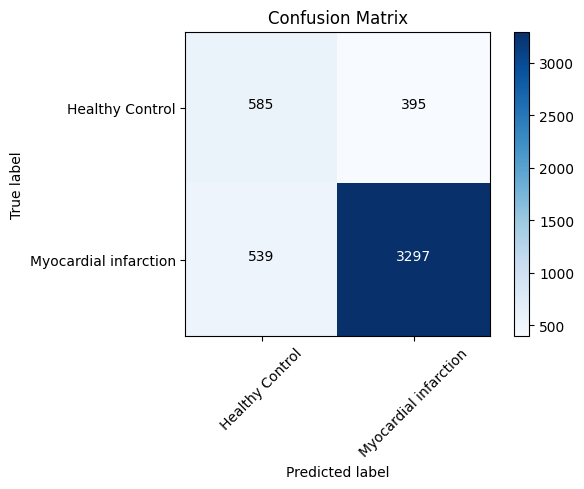

In [ ]:
cm_plot_labels = ['Healthy Control', 'Myocardial infarction']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization - 3 leads
[[ 628  289]
 [1565 2826]]


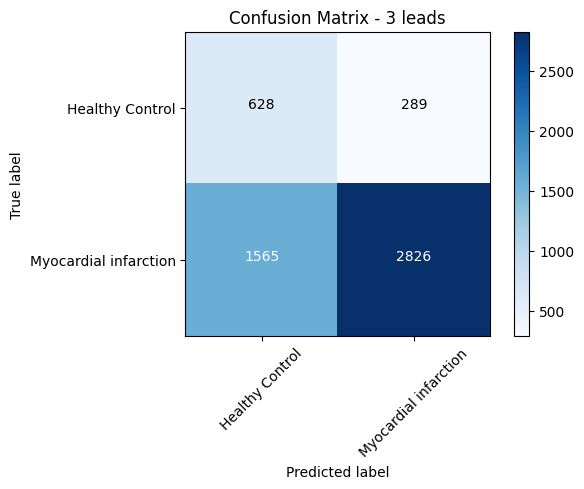

In [ ]:
cm_plot_labels = ['Healthy Control', 'Myocardial infarction']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix - 3 leads')

In [ ]:
def calculate_scores(prob,y_true,verbose=1):
    y_pred=[]
    for pb in prob:
        if np.argmax(pb)==0:
            y_pred.append(np.array([1,0]))
        if np.argmax(pb)==1:
            y_pred.append(np.array([0,1]))
    y_pred=np.array(y_pred)

    accuracy=np.sum(y_pred[:,0]==y_true[:,0])/y_true.shape[0]
    tp=0
    fp=0
    tn=0
    fn=0
    for y_p,y_t in zip(y_pred,y_true):
        if y_p[1]==1 and y_t[1]==1:
            tp=tp+1
        if y_p[1]==1 and y_t[1]==0:
            fp=fp+1
        if y_p[1]==0 and y_t[1]==0:
            tn=tn+1
        if y_p[1]==0 and y_t[1]==1:
            fn=fn+1
    if (tp+fn)==0:
        sensitivity='nan'
    else:
        sensitivity=tp/(tp+fn)
    if (tn+fp)==0:
        specificity='nan'
    else:
        specificity=tn/(tn+fp)
    scores={'accuracy':accuracy,'sensitivity':sensitivity,'specificity':specificity}
    if verbose:
        print('accuracy: {}\t sensitivity: {}\t specificity: {}'.format\
              (accuracy,sensitivity,specificity))
    return scores

In [ ]:
prob = model.predict(testX)

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


In [ ]:
scores = calculate_scores(prob, testY)

accuracy: 0.8060631229235881	 sensitivity: 0.8594890510948905	 specificity: 0.5969387755102041


In [ ]:

print('3 Leads Accuracy Scores')
scores = calculate_scores(prob, testY)

3 Leads Accuracy Scores
accuracy: 0.6507159005275056	 sensitivity: 0.6435891596447278	 specificity: 0.6848418756815703


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

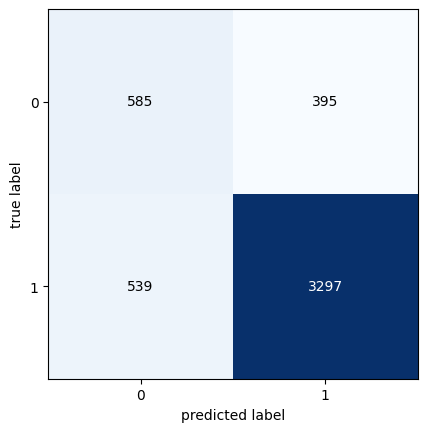

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

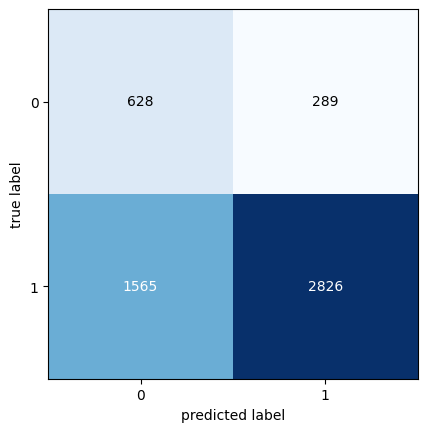

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf)


In [ ]:
print('Samples correctly classified 12 Lead Model:')
correct_idx = np.where(y_pred == y_true)[0]
print(correct_idx)

print('\nSamples incorrectly classified:')
incorrect_idx = np.where(y_pred != y_true)[0]
print(incorrect_idx)
print(len(correct_idx), len(incorrect_idx))

In [ ]:
print('Samples correctly classified by 3 Lead Model:')
correct_idx = np.where(y_pred == y_true)[0]
print(correct_idx)

print('\nSamples incorrectly classified:')
incorrect_idx = np.where(y_pred != y_true)[0]
print(incorrect_idx)
print(len(correct_idx), len(incorrect_idx))

Samples correctly classified by 3 Lead Model:
[   0    1    2 ... 5302 5305 5307]

Samples incorrectly classified:
[   6   10   11 ... 5303 5304 5306]
3454 1854


In [ ]:
print('Correctly Classified Index by 12 leads')
correct_idx[0:500]

In [ ]:
print('Correctly Classified Index by 3 leads')
correct_idx[0:500]

Correctly Classified Index by 3 leads


array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  12,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  73,  75,  76,  77,  78,  79,  80,  81,  84,  86,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116,
       117, 118, 119, 120, 122, 123, 124, 125, 126, 128, 129, 130, 131,
       134, 135, 137, 139, 140, 141, 143, 145, 146, 148, 149, 151, 152,
       153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       168, 169, 170, 172, 173, 174, 176, 178, 179, 180, 181, 183, 184,
       185, 188, 189, 191, 192, 194, 195, 196, 198, 199, 200, 203, 204,
       205, 206, 207, 208, 209, 210, 212, 217, 218, 219, 220, 22

In [ ]:
correct_infarct = testX[correct_idx[-2]]

In [ ]:
print('checking the classified by indicies of choice')
print("Correct label was", y_true[correct_idx[0]])
print("the predicted label is", y_pred[correct_idx[0]])
print("the record name for this task is", record_list[correct_idx[0]])
print("Correct label was", y_true[correct_idx[-2]])
print("the predicted label is", y_pred[correct_idx[-2]])
print("the record name for this task is", record_list[correct_idx[-2]])

checking the classified by indicies of choice
Correct label was 0
the predicted label is 0
the record name for this task is patient237/s0465_re
Correct label was 1
the predicted label is 1
the record name for this task is patient005/s0101lre


149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step


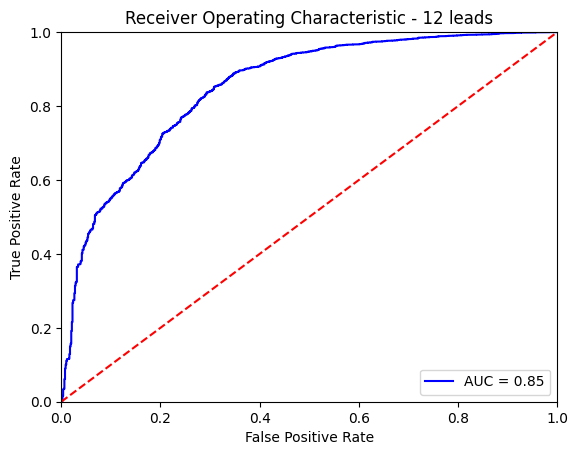

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = model.predict(testX)
preds = probs[:,1]
fpr, tpr, thresold = roc_curve(testY.argmax(axis=1), preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic - 12 leads')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


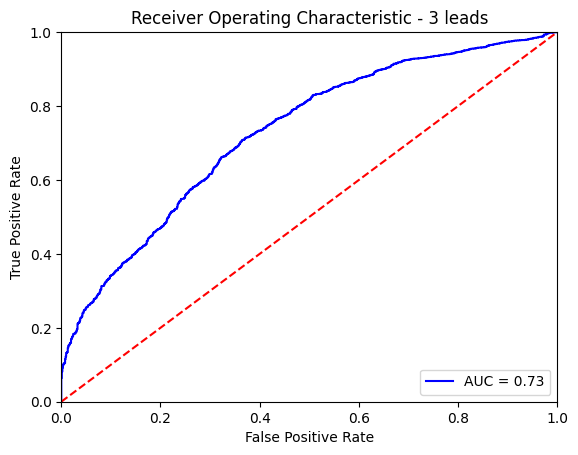

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = model1.predict(testX)
preds = probs[:,1]
fpr, tpr, thresold = roc_curve(testY.argmax(axis=1), preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Receiver Operating Characteristic - 3 leads')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
for i in correct_infarct:
  sig_names = record.sig_name
  plt.plot(i)

  plt.show()

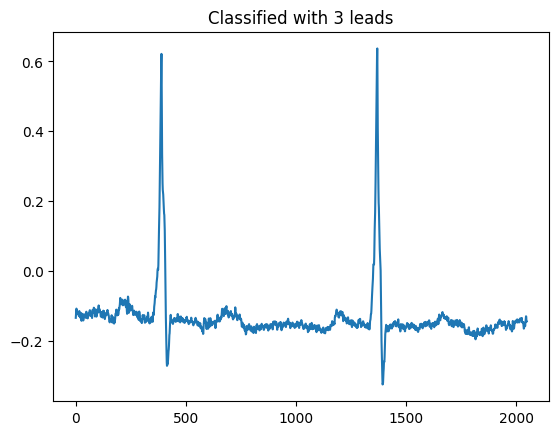

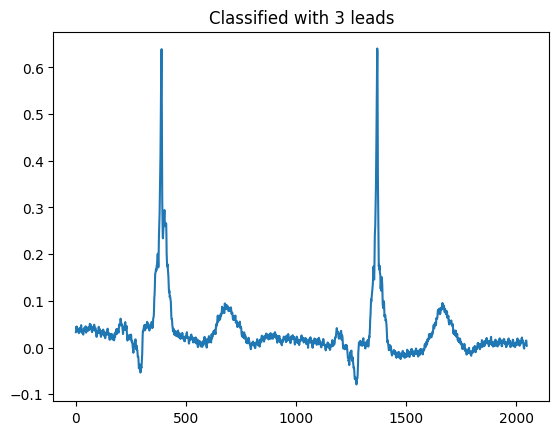

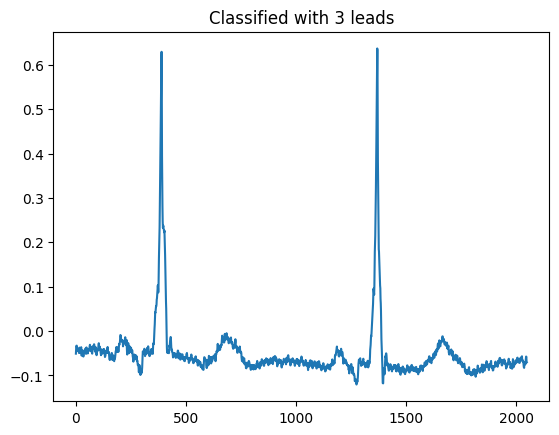

In [ ]:
for i in correct_infarct:
  sig_names = record.sig_name
  plt.plot(i)
  plt.title("Classified with 3 leads")

  plt.show()

In [ ]:
model.history.history.keys()

In [ ]:
model.evaluate(testX, testY)

166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6770 - loss: 0.7131


[0.7249423861503601, 0.6507158875465393]

In [ ]:
model.history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
model1.history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
# summarrize the history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title("Model accuracy - 12 leads")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train', 'test'], loc='upper left')

KeyError: 'accuracy'

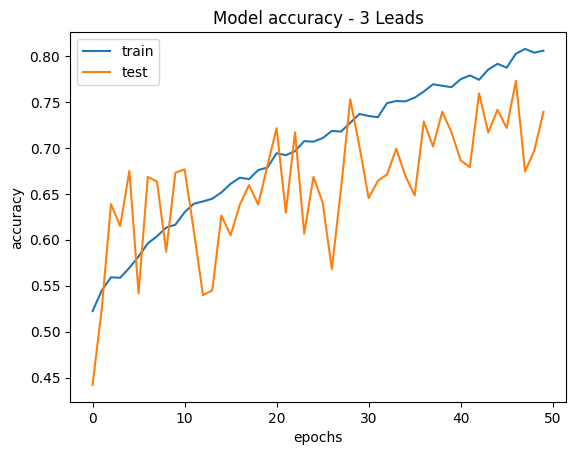

In [ ]:
# summarrize the history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title("Model accuracy - 3 Leads")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss - 12 leads')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

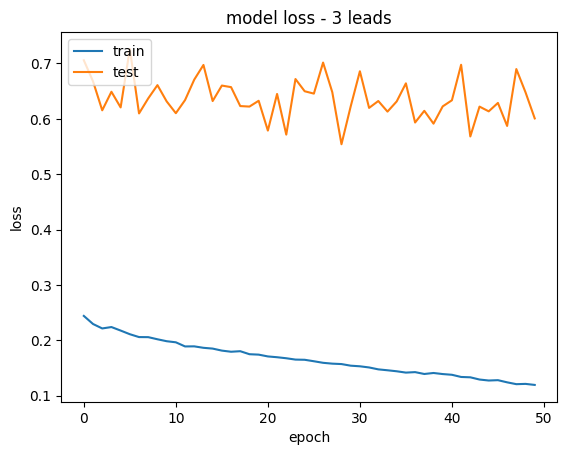

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss - 3 leads')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')